# Imports

In [68]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline


# Loading and Looking at Dataset

In [2]:
df = pd.read_csv('Terry_Stops.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54462 entries, 0 to 54461
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         54462 non-null  object
 1   Subject ID                54462 non-null  int64 
 2   GO / SC Num               54462 non-null  int64 
 3   Terry Stop ID             54462 non-null  int64 
 4   Stop Resolution           54462 non-null  object
 5   Weapon Type               54462 non-null  object
 6   Officer ID                54462 non-null  object
 7   Officer YOB               54462 non-null  int64 
 8   Officer Gender            54462 non-null  object
 9   Officer Race              54462 non-null  object
 10  Subject Perceived Race    54462 non-null  object
 11  Subject Perceived Gender  54462 non-null  object
 12  Reported Date             54462 non-null  object
 13  Reported Time             54462 non-null  object
 14  Initial Call Type     

In [4]:
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,26 - 35,-1,20170000475010,365576,Offense Report,None,7502,1981,M,White,...,22:06:00.0000000,"NARCOTICS WARRANT SERVICE - EXECUTED, SECURED",--NARCOTICS - NARCOTICS WARRANT SERVICE,"TELEPHONE OTHER, NOT 911",SOUTH PCT OPS - DAY ACT,N,Y,West,K,K3
1,36 - 45,-1,20160000300300,457869,Arrest,None,5727,1970,M,Asian,...,18:07:00.0000000,"NARCOTICS - VIOLATIONS (LOITER, USE, SELL, NARS)",--MISC MISD AND VIOLS - RECKLESS ENDANGERMENT,ONVIEW,WEST PCT OPS - MOUNTED PATROL,N,N,West,K,K2
2,26 - 35,-1,20150000004131,72536,Field Contact,None,7512,1970,M,White,...,21:57:00.0000000,-,-,-,SOUTH PCT 3RD W - ROBERT,N,N,South,S,S2
3,18 - 25,-1,20150000293740,75480,Offense Report,None,7403,1973,M,White,...,23:42:00.0000000,PROWLER - IP/JO,--PROWLER - TRESPASS,911,SOUTH PCT 3RD W - ROBERT,N,N,South,R,R1
4,46 - 55,-1,20170000004519,313328,Field Contact,None,5438,1958,M,White,...,17:39:00.0000000,-,-,-,SOUTHWEST PCT 2ND W - SOUTHWEST BEATS,N,N,-,-,-


In [5]:
df.shape

(54462, 23)

## Cleaning the Dataset

In [6]:
# Drop columns that will not be used 
df = df.drop(['Subject ID', 'GO / SC Num', 'Terry Stop ID', 'Sector', 'Beat', 'Officer Squad', 'Call Type'], axis=1)

In [7]:
# Create a new column called 'Arrest' and set it to 1 if the stop resolution was an arrest, and 0 otherwise
df['Arrest'] = df['Stop Resolution'].apply(lambda x: 1 if x == 'Arrest' else 0)

In [10]:
# Creating column coverting Officer YOB to Age
import datetime

current_year = datetime.datetime.now().year

def calculate_age(year_of_birth):
    return current_year - year_of_birth

df['Officer Age'] = df['Officer YOB'].apply(calculate_age)


In [12]:
# New column binning Officer Ages

bins = [20, 30, 40, 50, 60, 70]
df['Officer Age Group'] = pd.cut(df['Officer Age'], 
                            bins, labels=['20-30', '30-40', '40-50', '50-60', '60-70'])


In [44]:
# Combining Different Weapon Types
replacements = {
    'Blunt Object/Striking Implement': 'Blunt / Striking Object', 
    'Club, Blackjack, Brass Knuckles': 'Blunt / Striking Object',
    'Club': 'Blunt / Striking Object',
    'Brass Knuckles': 'Blunt / Striking Object',
    'Blackjack': 'Blunt / Striking Object', 
    'Lethal Cutting Instrument': 'Cutting / Stabbing Instrument',
    'Knife/Cutting/Stabbing Instrument': 'Cutting / Stabbing Instrument', 
    'Handgun': 'Firearm',
    'Firearm Other ': 'Firearm',
    'Firearm': 'Firearm',
    'Other Firearm': 'Firearm',
    'Firearm(unk type)': 'Firearm',
    'Rifle': 'Firearm',
    'Shotgun': 'Firearm', 
    'Automatic Handgun': 'Firearm',
    'None': 'None',
    '-': 'None',
    'None/Not applicable': 'None',
    'Mace/Pepper Spray': 'Other',
    'Taser/Stun Gun': 'Other',
    'Fire/Incendiary Device': 'Other',
    'Personal Weapons (hands, feet, etc.)': 'Other'
    
}

df['Weapon Type'] = df['Weapon Type'].replace(replacements)


In [47]:
df['Weapon Type'].value_counts()

None                             51105
Cutting / Stabbing Instrument     2496
Firearm                            476
Blunt / Striking Object            189
Other                               70
Name: Weapon Type, dtype: int64

In [48]:
# Combining Date and Time to a New Column 
df['Reported Date Time'] = df['Reported Date'] + ' ' + df['Reported Time']
df['Reported Date Time'] = pd.to_datetime(df['Reported Date Time'])

In [52]:
# Dropping the '-' and 'unknown from different columns
df.drop(df[df['Subject Age Group'] == '-'].index, inplace=True)
df.drop(df[df['Subject Perceived Race'] == '-'].index, inplace=True)
df.drop(df[df['Officer Race'] == 'Unknown'].index, inplace=True)

# Dropping unused keys in the 'Precinct' column
df.drop(df[df['Precinct'] == 'FK ERROR'].index, inplace=True)
df.drop(df[df['Precinct'] == 'OOJ'].index, inplace=True)

In [58]:
# Combining Unknown Values
replacements = {
    '-': 'Unknown',
    'Unknown ': 'Unknown '
}

df['Precinct'] = df['Precinct'].replace(replacements)

In [59]:
df.head(1)

,Subject Age Group,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,Subject Perceived Race,Subject Perceived Gender,Reported Date,Reported Time,Initial Call Type,Final Call Type,Arrest Flag,Frisk Flag,Precinct,Arrest,Officer Age,Officer Age Group,Reported Date Time
0,26 - 35,Offense Report,None,7502,1981,M,White,Multi-Racial,Female,2017-12-27T00:00:00Z,22:06:00.0000000,"NARCOTICS WARRANT SERVICE - EXECUTED, SECURED",--NARCOTICS - NARCOTICS WARRANT SERVICE,N,Y,West,0,42,40-50,2017-12-27 22:06:00+00:00


# Models

## Logistic Regression (First Simple Model)

In [61]:
X = df[['Subject Age Group', 'Officer Race', 'Officer Gender', 'Subject Perceived Race', 
        'Subject Perceived Gender', 'Officer Age']]
y = df['Arrest']

# One-hot encode the categorical variables
X = pd.get_dummies(X, columns=['Subject Age Group', 'Officer Race', 'Officer Gender', 
                               'Subject Perceived Race', 'Subject Perceived Gender'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
LR_model = LogisticRegression(max_iter=2000)

# Fit the model to the training data
LR_model.fit(X_train, y_train)

# Score the model on the test data
LR_score = LR_model.score(X_test, y_test)
LR_score

0.743836558294863

## Dummy Classifier (Baseline)

In [66]:
X = df[['Subject Age Group', 'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
y = df['Arrest']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')

# Fit the classifier to the training data
dummy_clf.fit(X_train, y_train)

# Predict on the test data
y_pred = dummy_clf.predict(X_test)

# Calculate the accuracy score
clf_accuracy = accuracy_score(y_test, y_pred)
clf_accuracy

0.743836558294863

## Random Forest 

In [121]:
X = df[['Subject Age Group', 'Officer Race', 'Officer Gender', 'Subject Perceived Race', 
        'Subject Perceived Gender', 'Officer Age']]
y = df['Arrest']

# Encode the categorical features as integers
X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a random forest classifier
rfc = RandomForestClassifier(max_depth=20, n_estimators=100,  criterion='gini', min_samples_split=5,
    min_samples_leaf=6, )

# Fit the classifier to the training data
rfc.fit(X_train, y_train)

# Predict on the test data
y_pred = rfc.predict(X_test)

scores = cross_val_score(rfc, X, y, cv=5)

# Calculate the accuracy score
rfc_accuracy = accuracy_score(y_test, y_pred)
rfc_accuracy

0.74255966997348

## Gradient Booster

In [118]:
X = df[['Subject Age Group', 'Officer Race', 'Officer Gender', 'Subject Perceived Race', 
        'Subject Perceived Gender', 'Officer Age']]
y = df['Arrest']

# Create a gradient boosting classifier
gbc = GradientBoostingClassifier(learning_rate=0.1, n_estimators=700, max_depth=5)

# Fit the classifier to the training data
gbc.fit(X_train, y_train)

# Predict on the test data
y_pred = gbc.predict(X_test)

# Calculate the accuracy score
gbc_accuracy = accuracy_score(y_test, y_pred)
gbc_accuracy

0.8339062960416462

## Decision Tree

In [122]:
# Prepare the data for modeling
X = df[['Subject Age Group', 'Officer Race', 'Officer Gender', 'Subject Perceived Race', 
        'Subject Perceived Gender', 'Officer Age']]
y = df['Arrest']

X = X.apply(LabelEncoder().fit_transform)
y = LabelEncoder().fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree classifier
dt = DecisionTreeClassifier(max_depth=10, criterion='entropy', splitter='best', min_samples_split=4,
    min_samples_leaf=4)

# Fit the classifier to the training data
dt.fit(X_train, y_train)

# Predict on the test data
y_pred = dt.predict(X_test)

# Calculate the accuracy score
dt_accuracy = accuracy_score(y_test, y_pred)
dt_accuracy

0.738925449366467

## ImPipeline

In [78]:

# Select the feature columns
X = df[['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct', 'Officer Age']]
y = df['Arrest']


# Define the preprocessing steps for the categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define the preprocessing steps for the numerical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the preprocessor
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, ['Subject Age Group', 'Weapon Type', 'Officer Gender', 'Officer Race',
       'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date',
       'Reported Time', 'Initial Call Type', 'Final Call Type',
       'Frisk Flag', 'Precinct']),
    ('num', numeric_transformer, ['Officer Age'])
])

# Create the model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Score the pipeline on the test data
score = pipeline.score(X_test, y_test)
print(f'Test score: {score:.2f}')

Test score: 0.74


In [79]:
num_pipe = Pipeline([
    ('num_impute', SimpleImputer(strategy='mean')),
    ('ss',StandardScaler())
])
cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

In [80]:
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, selector(dtype_include=np.number)),
    ('cat_trans', cat_pipe, selector(dtype_include=object))
],remainder='passthrough')

In [81]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

CV Results for `dummy` model:
            0.74635 ± 0.00007 accuracy
        


<AxesSubplot:title={'center':'CV Results for `dummy` Model'}>

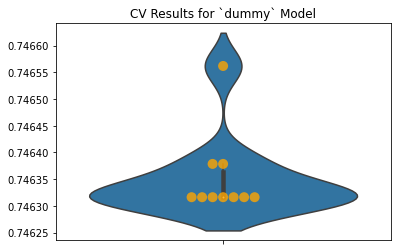

In [83]:
# Dummy model from pipeline
dummy_model = Pipeline([
    ('ct',CT),
    ('dummy',DummyClassifier(strategy='most_frequent'))
])

dummy_model_pipe =  ModelWithCV(dummy_model, model_name='dummy',X=X_train, y=y_train)
dummy_model_pipe.print_cv_summary()

fig,ax = plt.subplots()
dummy_model_pipe.plot_cv(ax=ax)

CV Results for `fsm` model:
            0.74493 ± 0.00240 accuracy
        


<AxesSubplot:title={'center':'CV Results for `fsm` Model'}>

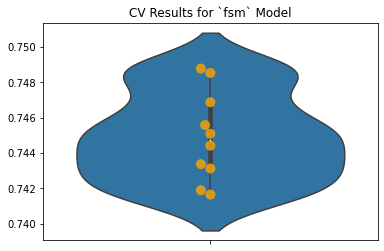

In [119]:
#LogReg from pipeline
logreg_fsm = Pipeline([
    ('ct',CT),
    ('logreg_fsm',LogisticRegression(random_state=42, max_iter=1000))
])

# Use the class with out logreg pipe
fsm_model_pipe =  ModelWithCV(logreg_fsm, model_name='fsm',X=X_train, y=y_train)
fsm_model_pipe.print_cv_summary()

fig,ax = plt.subplots()
fsm_model_pipe.plot_cv(ax=ax)

CV Results for `forest_pipe` model:
            0.83019 ± 0.00529 accuracy
        


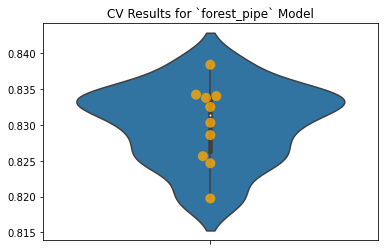

In [120]:
# Random Forrest from pipeline
rfc = RandomForestClassifier(random_state=42)

rfc_model_pipe = Pipeline([('ct', CT), ('rfc', rfc)])

forest_pipe = ModelWithCV(model=rfc_model_pipe,
                          model_name='forest_pipe',
                          X=X_train,
                          y=y_train)
forest_pipe.print_cv_summary()

fig, ax = plt.subplots()
forest_pipe.plot_cv(ax=ax);

# Visuals

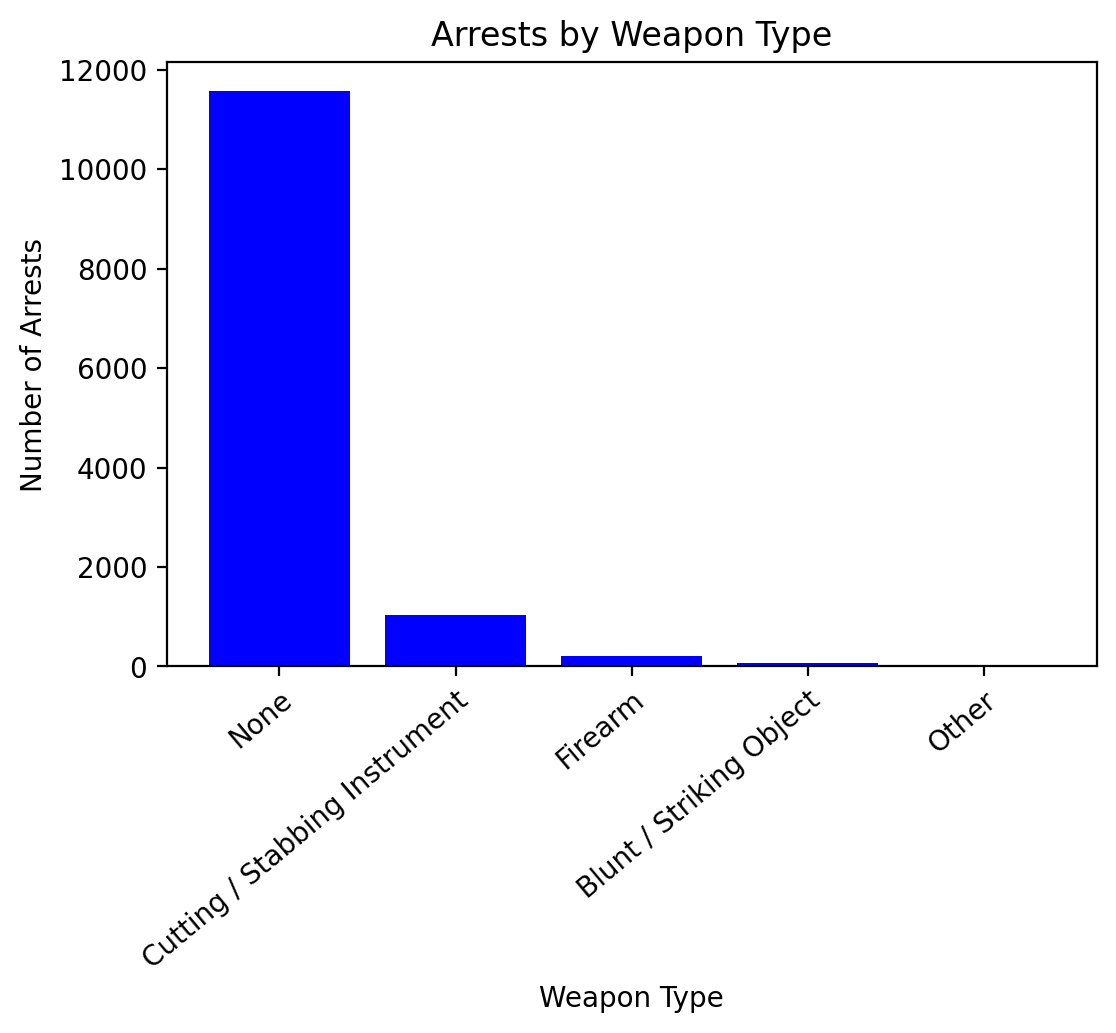

In [92]:
# Arrests Counts Per Weapon Type
arrest_counts_weapon = df[df['Stop Resolution'] == 'Arrest']['Weapon Type'].value_counts()
plt.figure(dpi = 200)

# Plot the counts as a bar chart
plt.bar(arrest_counts_weapon.index, arrest_counts_weapon.values, color='blue')
plt.xlabel('Weapon Type')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Weapon Type')
plt.xticks(rotation=40, rotation_mode='anchor', ha='right')
plt.show()

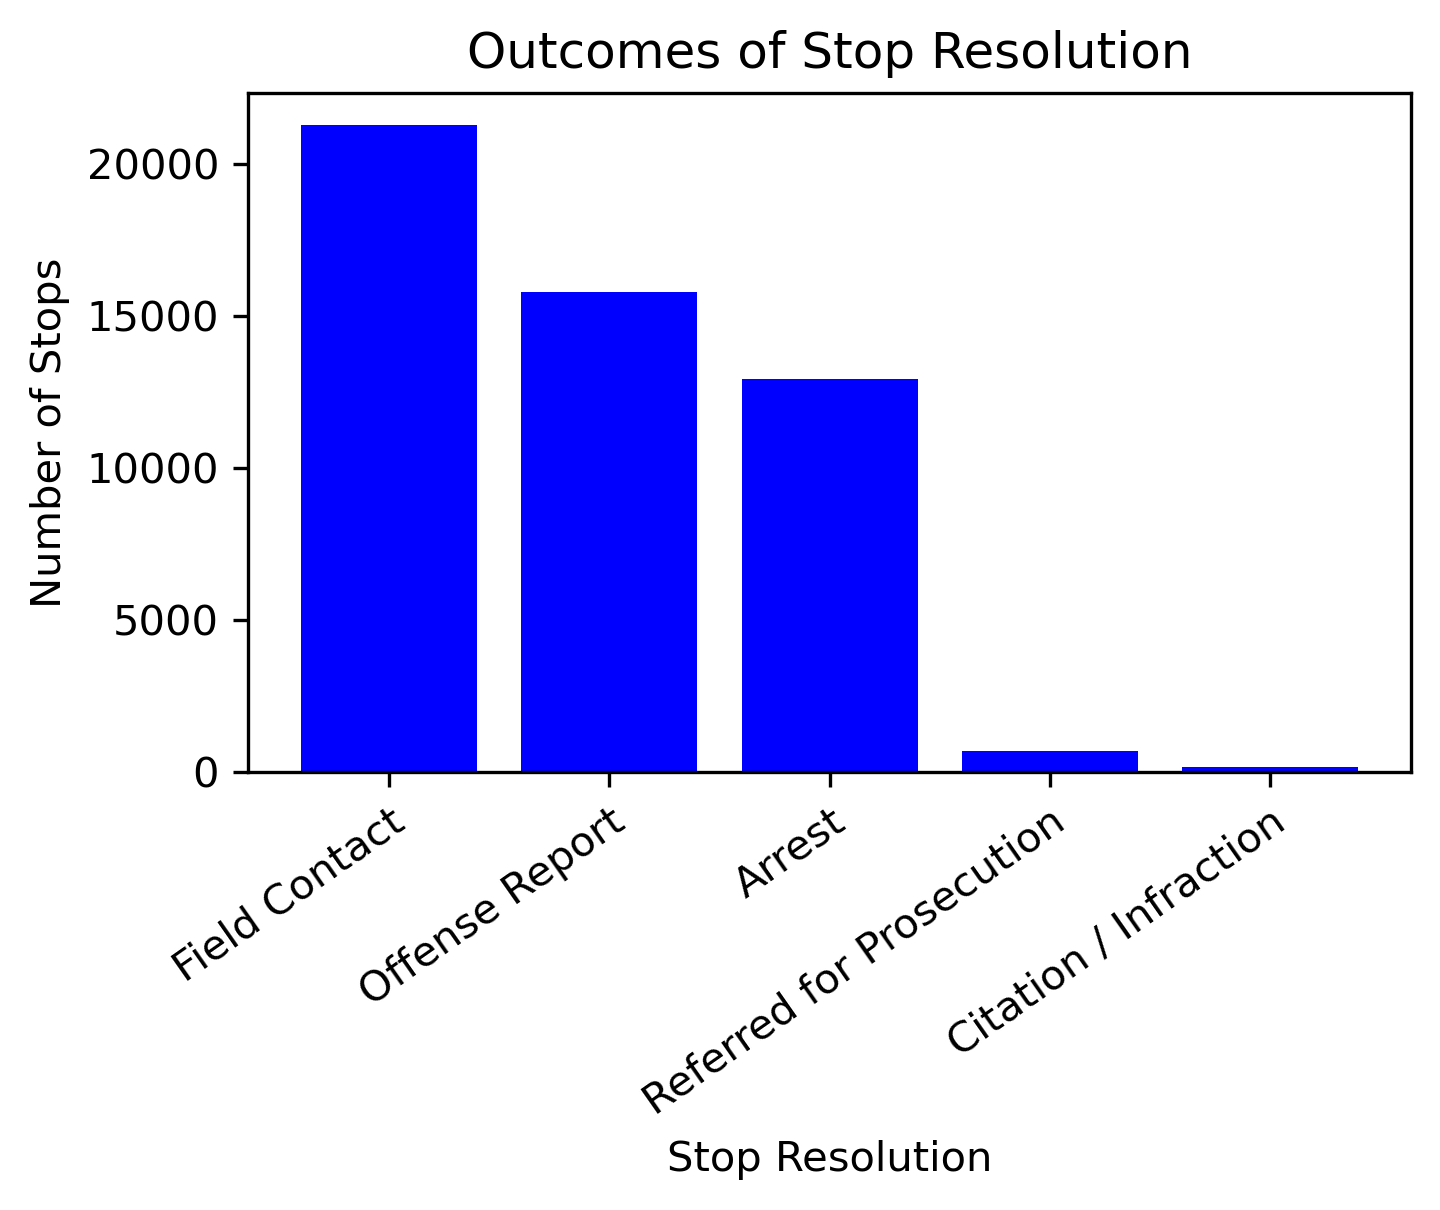

In [86]:
# Number of Stops and the Outcome
resolution_counts = df['Stop Resolution'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(resolution_counts.index, resolution_counts.values, color='blue')
plt.xlabel('Stop Resolution')
plt.ylabel('Number of Stops')
plt.title('Outcomes of Stop Resolution')
plt.xticks(rotation=35, rotation_mode='anchor', ha='right')
plt.show()

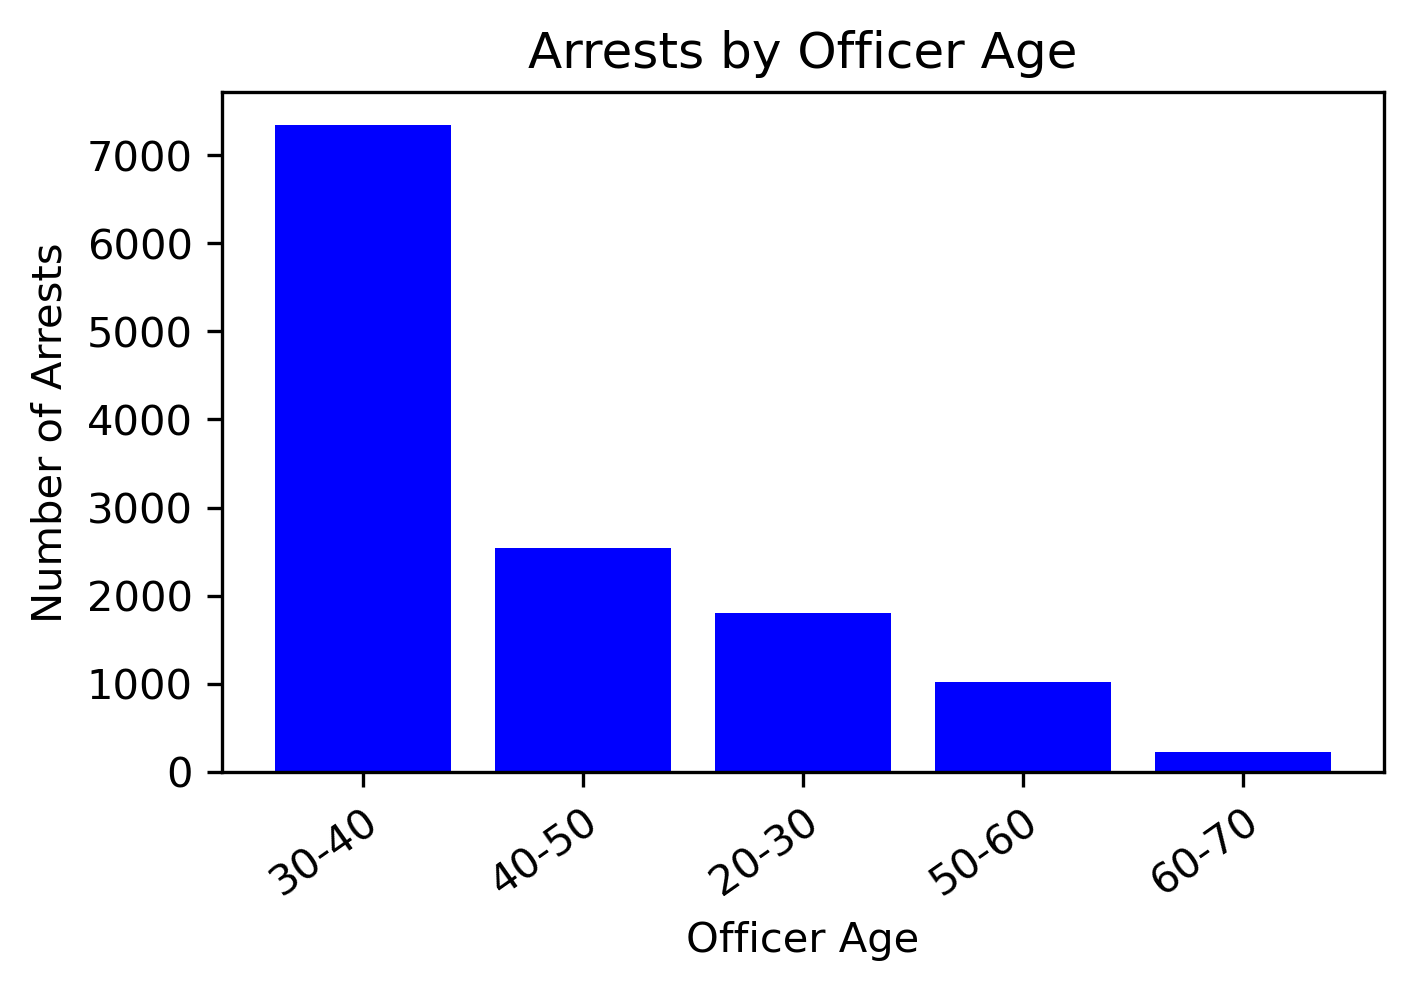

In [87]:
# Arrests by Officer Age
arrest_counts_officer = df[df['Stop Resolution'] == 'Arrest']['Officer Age Group'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_counts_officer.index, arrest_counts_officer.values, color='blue')
plt.xlabel('Officer Age')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Officer Age')
plt.xticks(rotation=35, rotation_mode='anchor', ha='right')

plt.show()


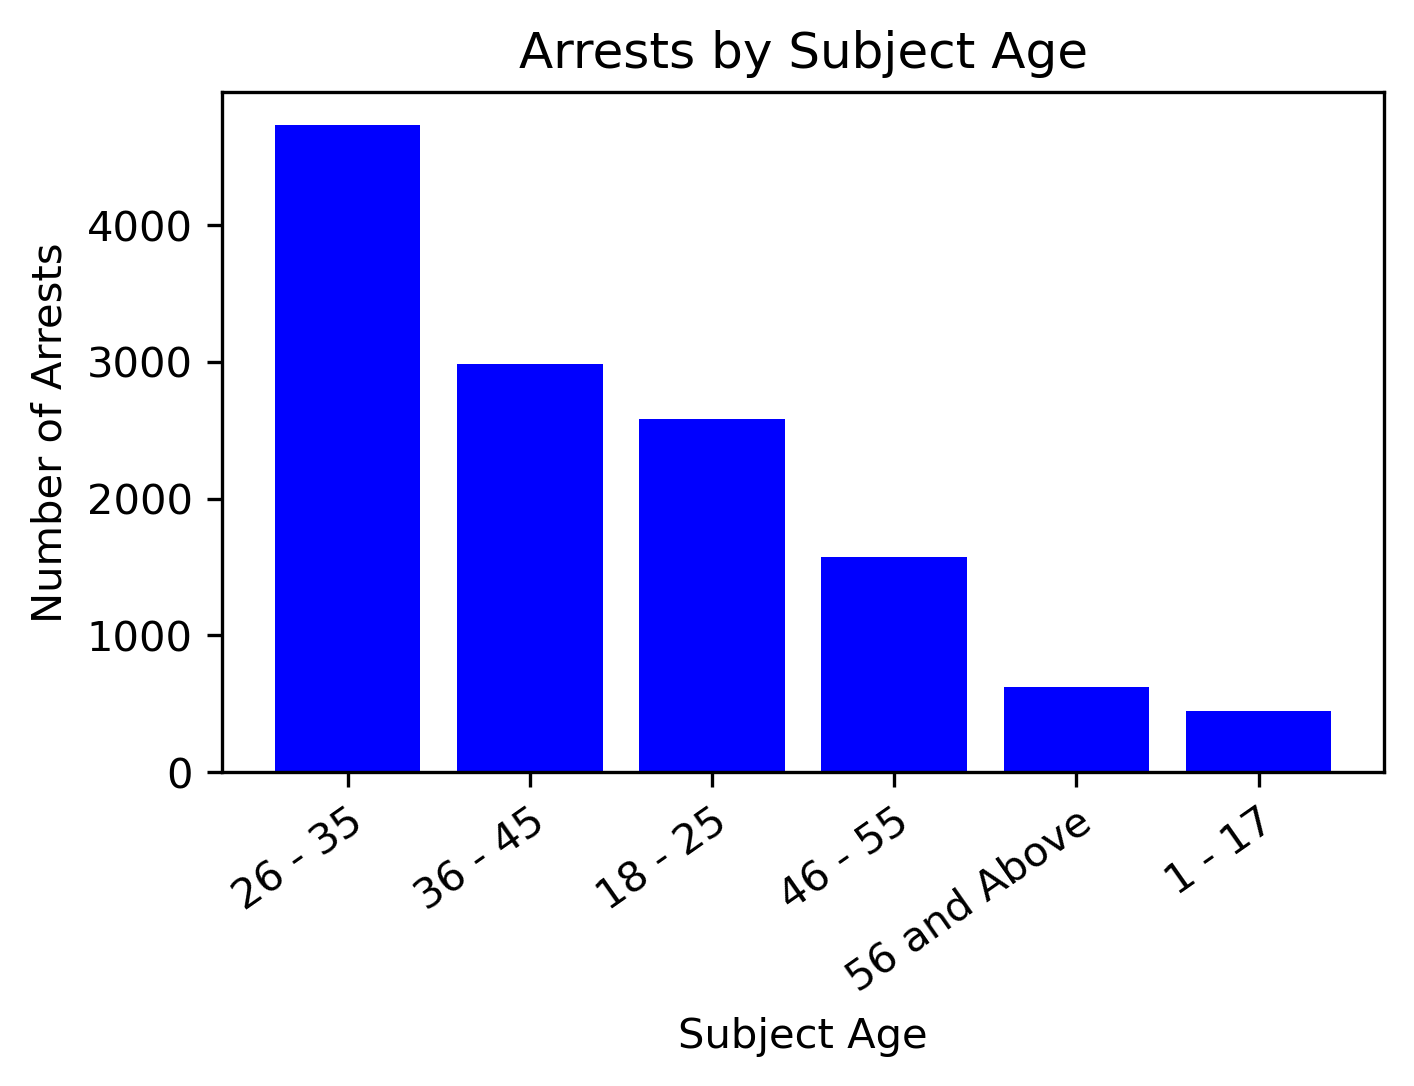

In [88]:
# Arrests by Subject Age
arrest_counts_subject = df[df['Stop Resolution'] == 'Arrest']['Subject Age Group'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_counts_subject.index, arrest_counts_subject.values, color='blue')
plt.xlabel('Subject Age')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Subject Age')
plt.xticks(rotation=35, rotation_mode='anchor', ha='right')
plt.show()

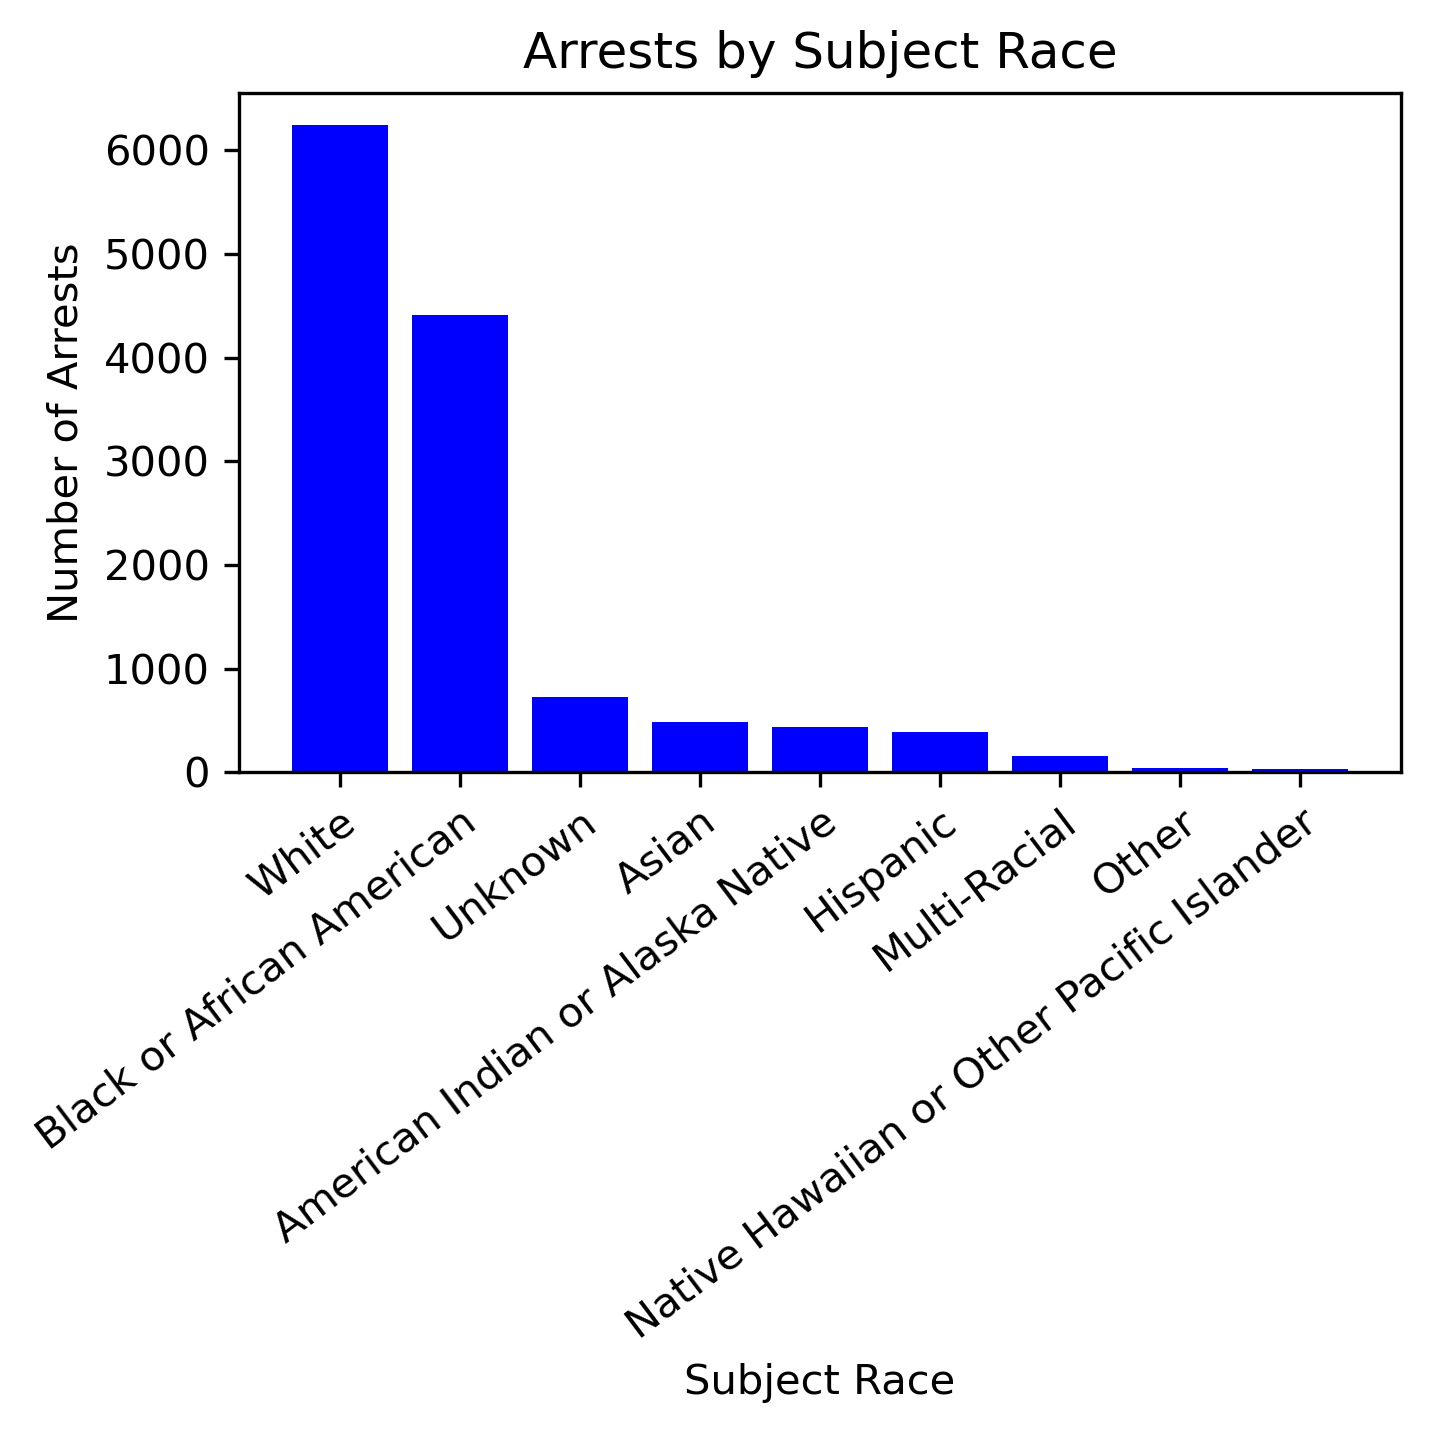

In [115]:
arrest_counts_subject_race = df[df['Stop Resolution'] == 'Arrest']['Subject Perceived Race'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_counts_subject_race.index, arrest_counts_subject_race.values, color='blue')
plt.xlabel('Subject Race')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Subject Race')
plt.xticks(rotation=37, rotation_mode='anchor', ha='right')
plt.show()


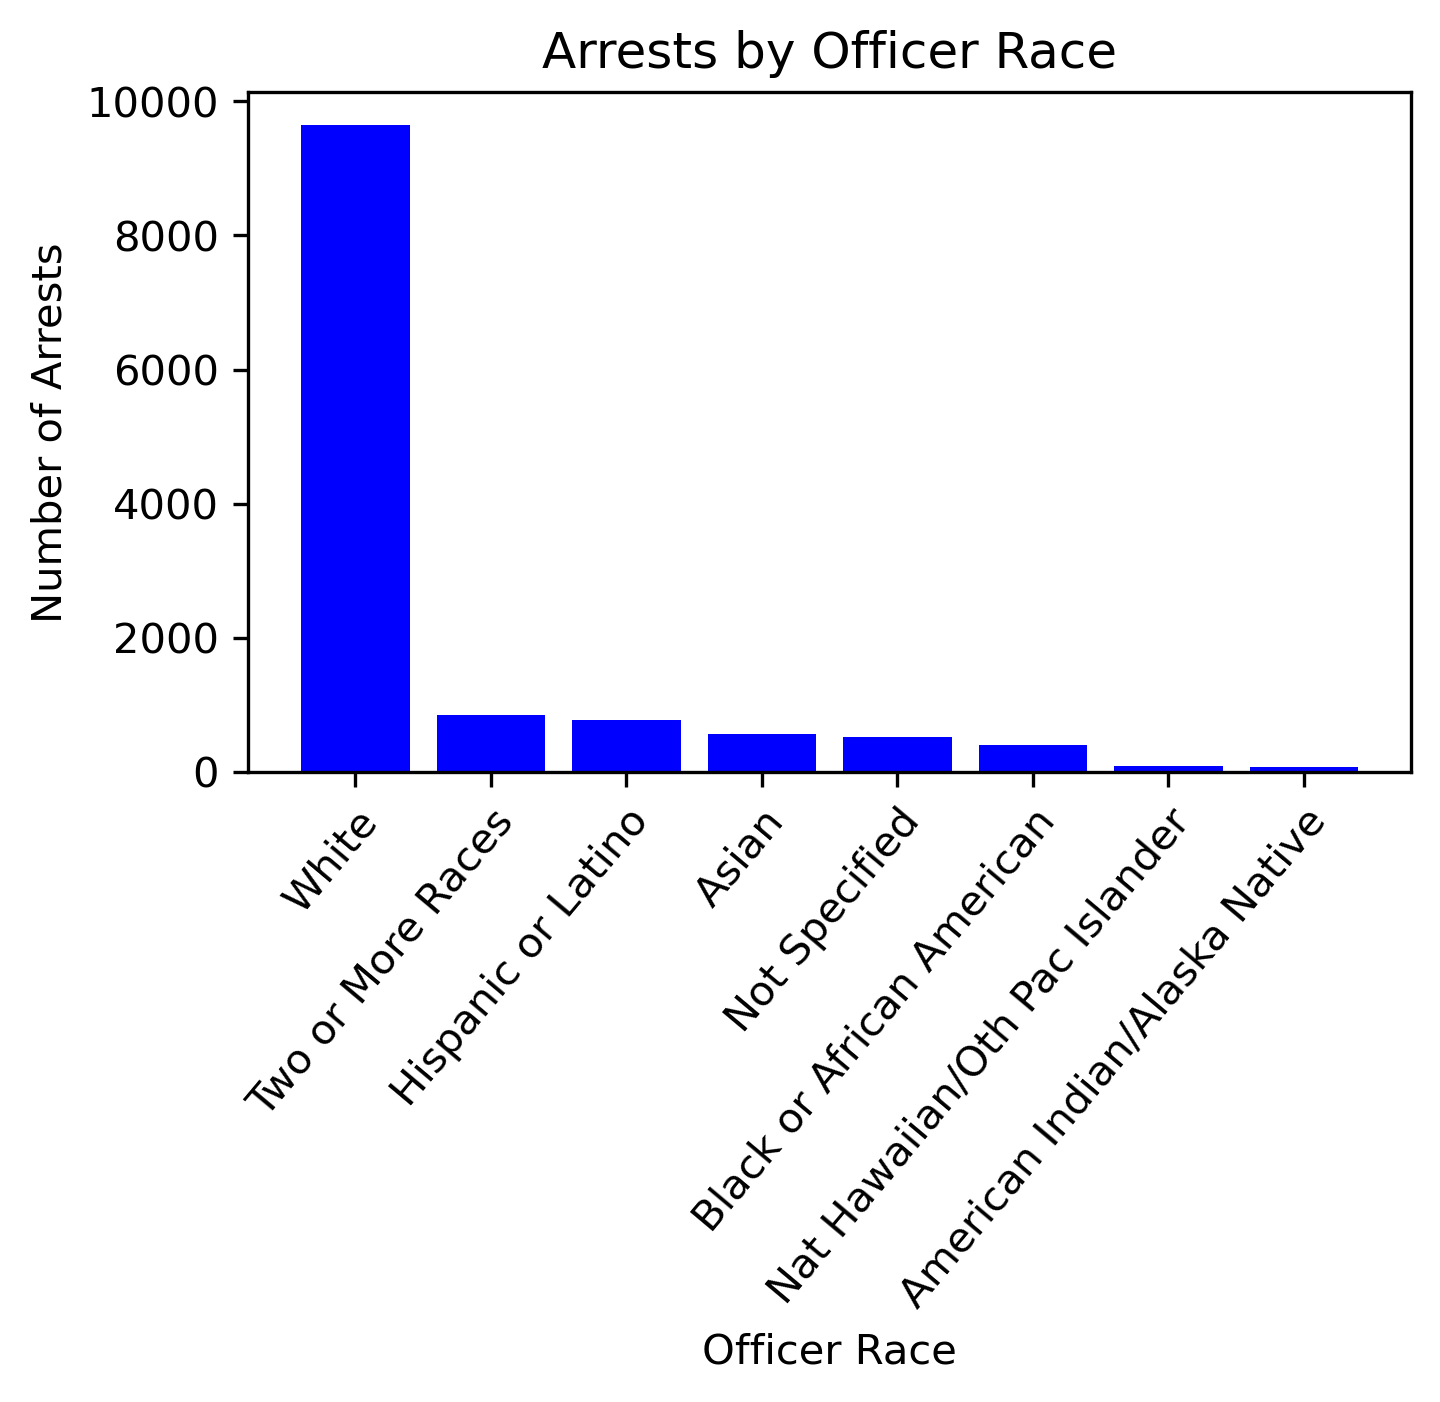

In [114]:
arrest_counts_officer_race = df[df['Stop Resolution'] == 'Arrest']['Officer Race'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize = (5,3), dpi = 300)
plt.bar(arrest_counts_officer_race.index, arrest_counts_officer_race.values, color='blue')
plt.xlabel('Officer Race')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Officer Race')
plt.xticks(rotation=50, rotation_mode='anchor', ha='right')
plt.show()

Text(0.5, 1.0, 'Arrests by Year')

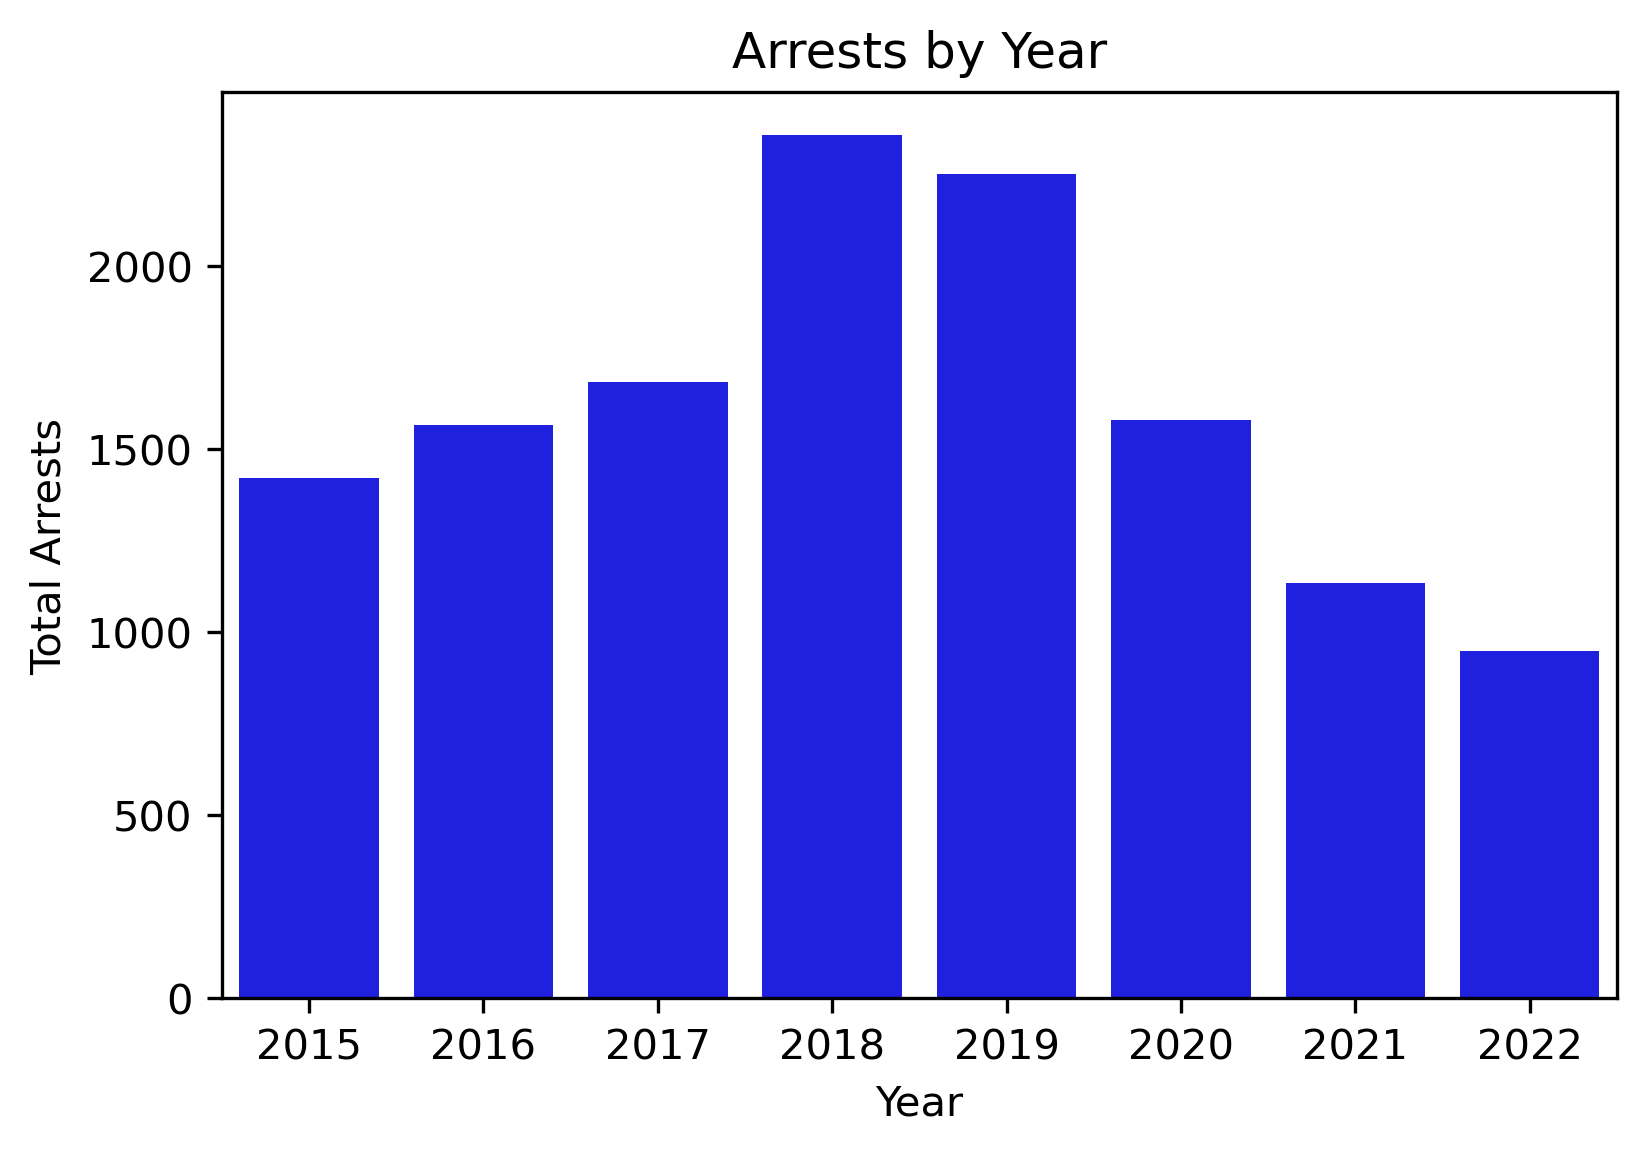

In [89]:
# Arrest by Year
arrests_by_year = df[df['Stop Resolution'] == 'Arrest'].groupby(df['Reported Date Time'].dt.year)['Stop Resolution'].size()

# Plot the counts as a bar chart
fig, ax = plt.subplots()
sns.barplot(x=arrests_by_year.index, y=arrests_by_year.values, color='blue', data=df).figure.set_dpi(300)
ax.set_xlabel('Year')
ax.set_ylabel('Total Arrests')
ax.set_title('Arrests by Year')


Text(0.5, 1.0, 'Arrests by Precinct')

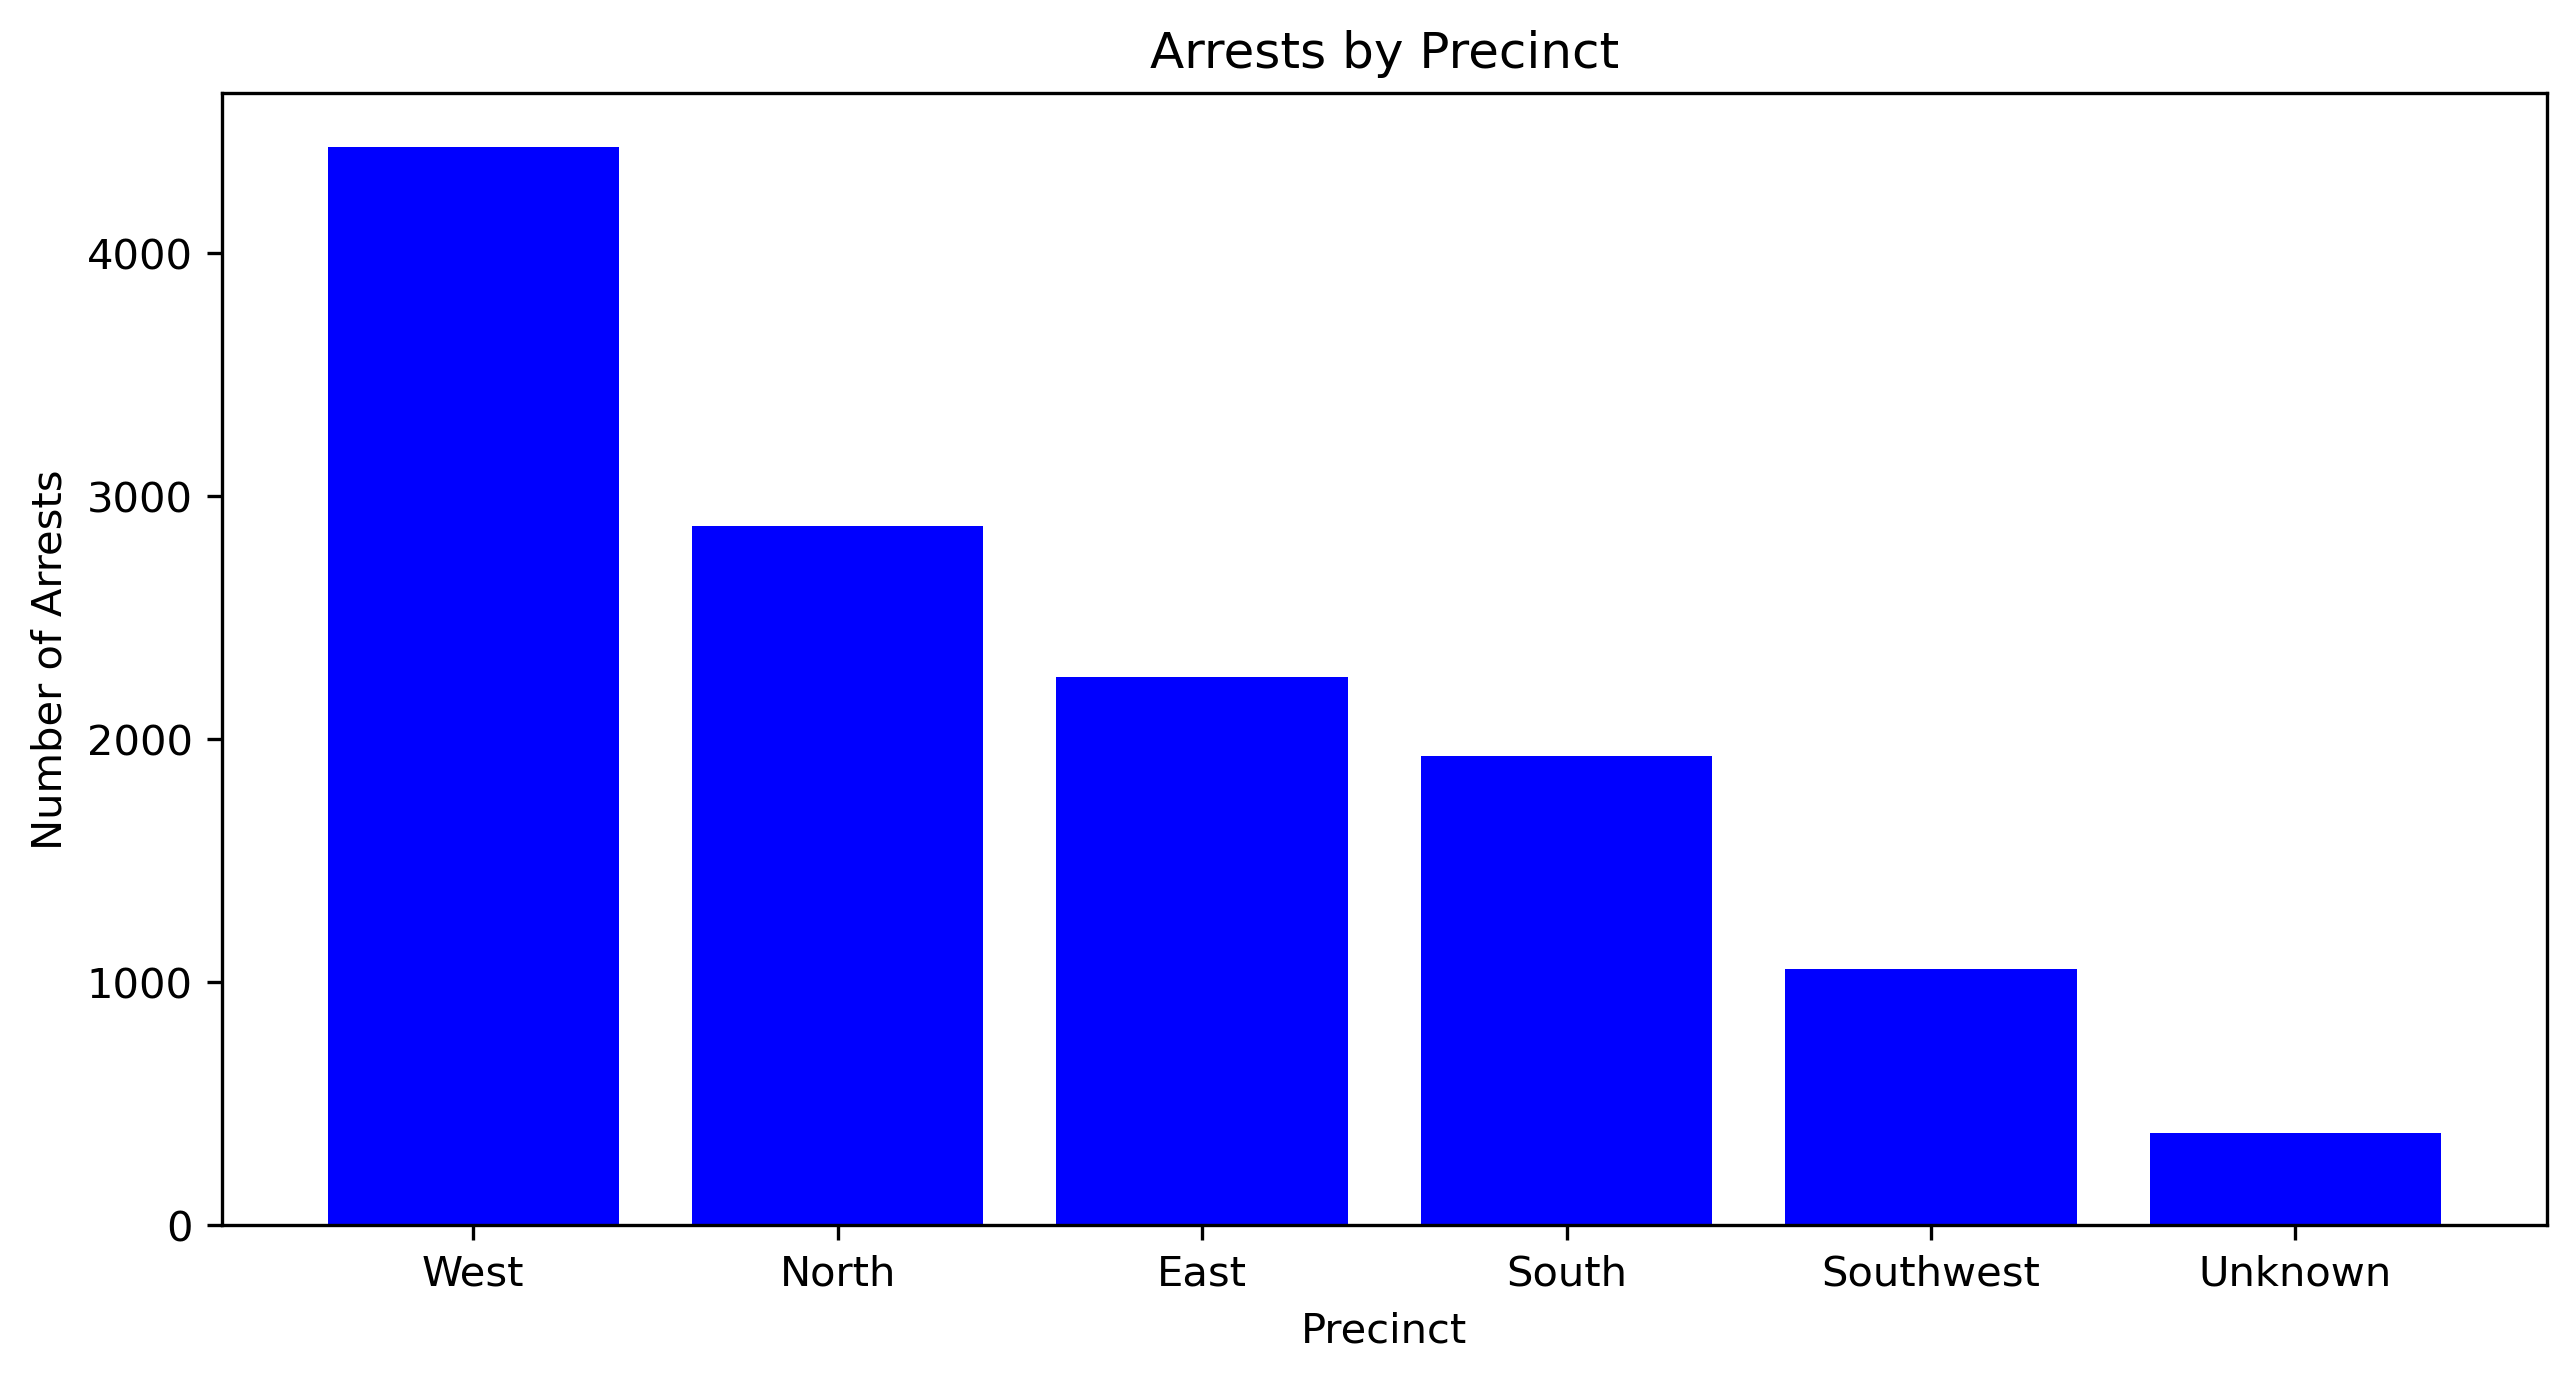

In [111]:
# Group the data by precinct and count the number of arrests for each precinct
arrest_counts_precinct = df[df['Stop Resolution'] == 'Arrest']['Precinct'].value_counts()
arrest_counts_precinct.drop('Unknown')

plt.figure(figsize = (10,5), dpi = 300)
plt.bar(arrest_counts_precinct.index, arrest_counts_precinct.values, color='blue')
plt.xlabel('Precinct')
plt.ylabel('Number of Arrests')
plt.title('Arrests by Precinct')